In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
import seaborn as sns
sns.set_style("white")
sns.set(context='notebook',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})

import contextlib
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import itertools
from scipy.stats import fisher_exact

In [18]:
# support functions
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [3]:
def mse(p, delta, n, m):
    q = p + delta
    nom = n*p*(1-p) + m*q*(1-q) + m**2*(p-q)**2
    denom = (n+m)**2
    return nom/denom

In [4]:
p = 0.5
delta_list = np.arange(0, 0.3+1e-3, 0.05)
n = 4
m_list = np.arange(0, 20, 0.1)

In [5]:
mse_list = []
for delta in delta_list:
    mse_delta = []
    for m in m_list:
        mse_delta.append(mse(p, delta, n, m))
    mse_list.append(mse_delta)
mse_list = np.array(mse_list)

Text(0.5, 1.0, '$p = 0.5, q = p + \\Delta$')

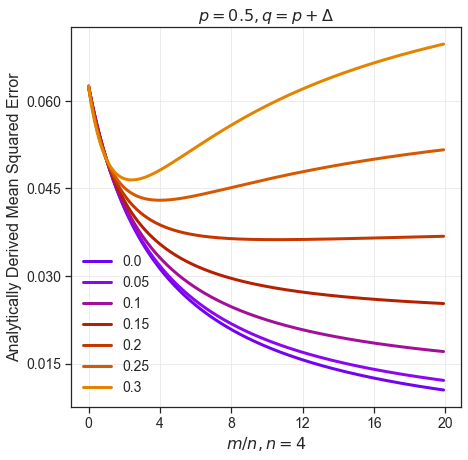

In [6]:
fontsize = 16
labelsize = 14
fig, ax = plt.subplots(figsize=(7, 7))
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0.2, 0.8, len(delta_list))]
for i, delta in enumerate(delta_list):
    ax.plot(m_list, mse_list[i], c=cmap[i], lw=3, label=str(np.round(delta, 2)))
ax.set_ylabel("Analytically Derived Mean Squared Error", fontsize=fontsize)
ax.set_xlabel(r"$m/n, n=4$", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.legend(fontsize=labelsize, frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.set_title(r"$p = {}, q = p + \Delta$".format(p), fontsize=fontsize)

### Comparing the Hodges estimator with the naive and combined estimators

In [19]:
def get_teststat(p_hat, q_hat, n, m):
    nom = np.abs(p_hat - q_hat)
    p_bar = (n * p_hat + m * q_hat)/(n + m)
    denom = np.sqrt( p_bar * (1 - p_bar) * (1/n + 1/m) )
    return nom / denom

def get_ideal_criterion(delta, p, n, m):
    coeff = [m*(m-1)/(n+m)**2, m*(1-2*p)/(n+m)**2, -m*p*(1-p)/(n*(n+m))]
    thresh = np.roots(coeff)
    thresh = thresh[thresh > 0]
    return delta - thresh

def get_criterion(p_hat, q_hat, n, m):
    p = p_hat
    delta = q_hat - p_hat
    coeff = [m*(m-1)/(n+m)**2, m*(1-2*p)/(n+m)**2, -m*p*(1-p)/(n*(n+m))]
    thresh = np.roots(coeff)
    thresh = thresh[thresh > 0]
    return delta - thresh

def do_fishers_test(p_hat, q_hat, n, m):
    n1 = p_hat * n
    m1 = q_hat * m
    table = np.array([[n1, m1], [n-n1, m-m1]])
    oddsr, p = fisher_exact(table, alternative='two-sided')
    return p

def compute_squared_error(delta, p, p_hat, q_hat, n, m):
    # T = get_ideal_criterion(delta, p, n, m)
    # T = get_teststat(p_hat, q_hat, n, m)
    # T = get_criterion(p_hat, q_hat, n, m)
    pval = do_fishers_test(p_hat, q_hat, n, m)
    p_bar = (n * p_hat + m * q_hat)/(n + m)
    mse_comb = (p_bar - p)**2
    mse_naive = (p_hat - p)**2
    mse = 0
    if pval < 0.05:
        mse = mse_naive
    else:
        mse = mse_comb
    return mse_naive, mse_comb, mse

In [8]:
p = 0.5
delta_list = np.arange(0, 0.5+1e-3, 0.05)
n = 50
m_list = [50, 100, 150]
reps = 100000

In [9]:
p_hat_array = np.random.binomial(n, p, reps) / n

hodges_list = []
comb_list = []

hodges_stdev_list = []
comb_stdev_list = []

for m in m_list:
    
    hodges_mse_list = []
    naive_mse_list = []
    comb_mse_list = []

    # hodges_std_list = []
    # naive_std_list = []
    # comb_std_list = []
    
    for delta in delta_list: 
        q = p + delta

        q_hat_array = np.random.binomial(m, q, reps) / m

        f = lambda p_hat, q_hat : compute_squared_error(delta, p, p_hat, q_hat, n, m)

        with tqdm_joblib(tqdm(desc="Compute Acc", total=reps)) as progress_bar:
            ses = np.array(Parallel(n_jobs=-1)(delayed(f)(p_hat_array[i], q_hat_array[i]) for i in range(reps)))
        
        mses = np.mean(ses, axis=0)
        naive_mse_list.append(mses[0])
        comb_mse_list.append(mses[1])
        hodges_mse_list.append(mses[2])

        # stds = np.std(ses, axis=0)

        # naive_std_list.append(stds[0])
        # comb_std_list.append(stds[1])
        # hodges_std_list.append(stds[2])

        
    hodges_list.append(hodges_mse_list)
    comb_list.append(comb_mse_list)

    # hodges_stdev_list.append(hodges_std_list)
    # comb_stdev_list.append(comb_std_list)
    
hodges_list = np.array(hodges_list)   
naive_list = np.array(naive_mse_list)
comb_list = np.array(comb_list)

# hodges_stdev_list = np.array(hodges_stdev_list)   
# naive_stdev_list = np.array(naive_std_list)
# comb_stdev_list = np.array(comb_stdev_list)

Compute Acc: 100%|██████████| 100000/100000 [00:03<00:00, 31841.91it/s]


Text(0.5, 1.0, '$p = 0.5, q = p + \\Delta, n = 50, m = 50$')

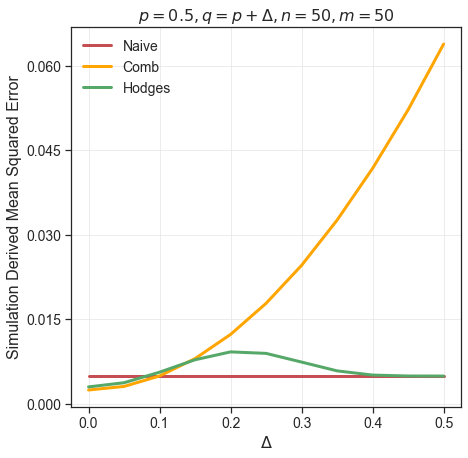

In [10]:
fontsize = 16
labelsize = 14
fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(delta_list, naive_list, c='r', lw=3, label="Naive")
ax.plot(delta_list, comb_list[0], c='orange', lw=3, label="Comb")
ax.plot(delta_list, hodges_list[0], c='g', lw=3, label="Hodges".format(m_list[0]))

# ax.errorbar(delta_list, naive_list, yerr=naive_stdev_list/np.sqrt(reps), color='r', solid_capstyle='projecting', capsize=5)
# ax.errorbar(delta_list, comb_list[0], yerr=comb_stdev_list[0]/np.sqrt(reps), color='orange', solid_capstyle='projecting', capsize=5)
# ax.errorbar(delta_list, hodges_list[0], yerr=hodges_stdev_list[0]/np.sqrt(reps), color='g', solid_capstyle='projecting', capsize=5)

ax.set_ylabel("Simulation Derived Mean Squared Error", fontsize=fontsize)
# ax.set_xlabel(r"$m/n, n=4$", fontsize=fontsize)
ax.set_xlabel(r"$\Delta$", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.legend(fontsize=labelsize, frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.set_title(r"$p = {}, q = p + \Delta, n = {}, m = {}$".format(p, n, m_list[0]), fontsize=fontsize)

Text(0.5, 1.0, '$p = 0.5, q = p + \\Delta, n = 50$')

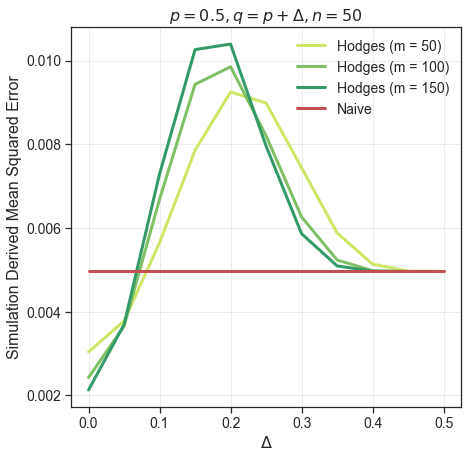

In [11]:
fontsize = 16
labelsize = 14
fig, ax = plt.subplots(figsize=(7, 7))
cmap = [plt.cm.summer_r(i) for i in np.linspace(0.2, 0.8, len(m_list))]
for i in range(len(m_list)):
    ax.plot(delta_list, hodges_list[i], c=cmap[i], lw=3, label="Hodges (m = {})".format(m_list[i]))
ax.plot(delta_list, naive_list, c='r', lw=3, label="Naive")
ax.set_ylabel("Simulation Derived Mean Squared Error", fontsize=fontsize)
# ax.set_xlabel(r"$m/n, n=4$", fontsize=fontsize)
ax.set_xlabel(r"$\Delta$", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.legend(fontsize=labelsize, frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.set_title(r"$p = {}, q = p + \Delta, n = {}$".format(p, n), fontsize=fontsize)

### Quick Example with the Normal Distribution

In [12]:
def get_teststat(mu1_hat, mu2_hat, n, m, sigma):
    nom = np.abs(mu1_hat - mu2_hat)
    denom = sigma * np.sqrt(1/n + 1/m)
    return nom / denom

def compute_squared_error(delta, mu1, sigma, mu1_hat, mu2_hat, n, m):
    T = get_teststat(mu1_hat, mu2_hat, n, m, sigma)
    mu_bar = (n * mu1_hat + m * mu2_hat)/(n + m)
    mse_comb = (mu_bar - mu1)**2
    mse_naive = (mu1_hat - mu1)**2
    mse = 0
    if T > 2.57:
        mse = mse_naive
    else:
        mse = mse_comb
    return mse_naive, mse_comb, mse

In [13]:
mu1 = 0
sigma = 1
delta_list = np.arange(0, 3.5+1e-3, 0.1)
n = 10
m_list = [20] #[4, 8, 12, 16, 20]
reps = 100000

In [14]:
mu1_hat_array = np.random.multivariate_normal(mu1 * np.ones(n), sigma * np.eye(n), reps).sum(axis=1)/n

hodges_list = []
comb_list = []

hodges_stdev_list = []
comb_stdev_list = []

for m in m_list:
    
    hodges_mse_list = []
    naive_mse_list = []
    comb_mse_list = []

    # hodges_std_list = []
    # naive_std_list = []
    # comb_std_list = []
    
    for delta in delta_list: 
        mu2 = mu1 + delta

        mu2_hat_array = np.random.multivariate_normal(mu2 * np.ones(m), sigma * np.eye(m), reps).sum(axis=1)/m

        f = lambda mu1_hat, mu2_hat : compute_squared_error(delta, mu1, sigma, mu1_hat, mu2_hat, n, m)

        with tqdm_joblib(tqdm(desc="Compute Acc", total=reps)) as progress_bar:
            ses = np.array(Parallel(n_jobs=-1)(delayed(f)(mu1_hat_array[i], mu2_hat_array[i]) for i in range(reps)))
        
        mses = np.mean(ses, axis=0)
        naive_mse_list.append(mses[0])
        comb_mse_list.append(mses[1])
        hodges_mse_list.append(mses[2])

        # stds = np.std(ses, axis=0)

        # naive_std_list.append(stds[0])
        # comb_std_list.append(stds[1])
        # hodges_std_list.append(stds[2])

        
    hodges_list.append(hodges_mse_list)
    comb_list.append(comb_mse_list)

    # hodges_stdev_list.append(hodges_std_list)
    # comb_stdev_list.append(comb_std_list)
    
hodges_list = np.array(hodges_list)   
naive_list = np.array(naive_mse_list)
comb_list = np.array(comb_list)

# hodges_stdev_list = np.array(hodges_stdev_list)   
# naive_stdev_list = np.array(naive_std_list)
# comb_stdev_list = np.array(comb_stdev_list)

Compute Acc: 100%|██████████| 100000/100000 [00:00<00:00, 120720.73it/s]


(0.0, 0.5)

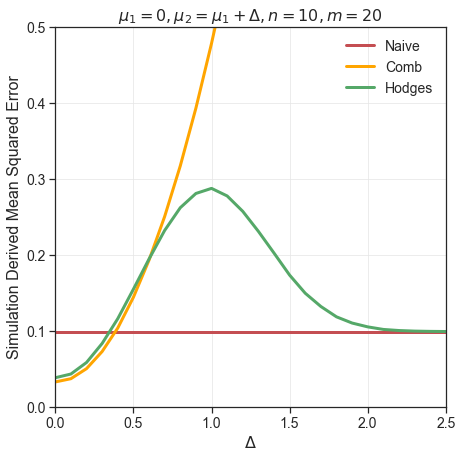

In [15]:
fontsize = 16
labelsize = 14
fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(delta_list, naive_list, c='r', lw=3, label="Naive")
ax.plot(delta_list, comb_list[0], c='orange', lw=3, label="Comb")
ax.plot(delta_list, hodges_list[0], c='g', lw=3, label="Hodges".format(m_list[0]))

# ax.errorbar(delta_list, naive_list, yerr=naive_stdev_list/np.sqrt(reps), color='r', solid_capstyle='projecting', capsize=5)
# ax.errorbar(delta_list, comb_list[0], yerr=comb_stdev_list[0]/np.sqrt(reps), color='orange', solid_capstyle='projecting', capsize=5)
# ax.errorbar(delta_list, hodges_list[0], yerr=hodges_stdev_list[0]/np.sqrt(reps), color='g', solid_capstyle='projecting', capsize=5)

ax.set_ylabel("Simulation Derived Mean Squared Error", fontsize=fontsize)
# ax.set_xlabel(r"$m/n, n=4$", fontsize=fontsize)
ax.set_xlabel(r"$\Delta$", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.legend(fontsize=labelsize, frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.set_title(r"$\mu_1 = {}, \mu_2 = \mu_1 + \Delta, n = {}, m = {}$".format(mu1, n, m_list[0]), fontsize=fontsize)
ax.set_xlim([0, 2.5])
ax.set_ylim([0, 0.5])

Text(0.5, 1.0, '$\\mu_1 = 0, \\mu_2 = \\mu_1 + \\Delta, n = 10$')

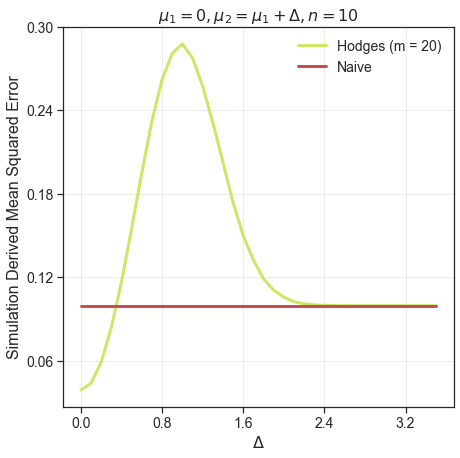

In [16]:
fontsize = 16
labelsize = 14
fig, ax = plt.subplots(figsize=(7, 7))
cmap = [plt.cm.summer_r(i) for i in np.linspace(0.2, 0.8, len(m_list))]
for i in range(len(m_list)):
    ax.plot(delta_list, hodges_list[i], c=cmap[i], lw=3, label="Hodges (m = {})".format(m_list[i]))
ax.plot(delta_list, naive_list, c='r', lw=3, label="Naive")
ax.set_ylabel("Simulation Derived Mean Squared Error", fontsize=fontsize)
# ax.set_xlabel(r"$m/n, n=4$", fontsize=fontsize)
ax.set_xlabel(r"$\Delta$", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.legend(fontsize=labelsize, frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.set_title(r"$\mu_1 = {}, \mu_2 = \mu_1 + \Delta, n = {}$".format(mu1, n), fontsize=fontsize)